Название: Неконтекстные представления

Реализовать свои неконтекстные представления (эмбединги) с нуля.

Выполнила: Чванкина Дарья

Цель работы: Провести анализ неконстектного представления. Реализовать их.

Датасет: Twitter US Airline Sentiment, 
https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

Выбранные сети для анализа: CBOW Word2Vec

In [395]:
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import time
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
from torch.optim.lr_scheduler import StepLR
from torch import optim
from sklearn.neighbors import NearestNeighbors

Word2Vec - один из самых эффективных методов создания вложений. Метод заключается в том, чтобы обучить нейросеть и иметь наилучшее признаковое пространство для текстовых данных. Далле это пространство можно анализировать и делать выводы из анализа.

### Некоторые вспомогательные функции

In [414]:
data = pd.read_csv('/content/drive/MyDrive/Данные/Tweets.csv') # данные представляют собой твиты об авиакомпаниях
data = data[['text']]
#приведение текстов к нижнему регситру
data['text'] = data['text'].apply(lambda x: x.lower())
#убираем из текста все символы, кроме букв, цифр
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#токенизация
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(data.text)

In [415]:
#проверка
data.text[0], tokenized_corpus[0]

('virginamerica what dhepburn said',
 ['virginamerica', 'what', 'dhepburn', 'said'])

In [416]:
# one hot enconding
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [417]:
freq = {}
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in list(freq.keys()):
            freq[token] = 1
        else:
            freq[token] += 1

#функция для создания словаря
def get_vocabulary(freq, top_n_words):

    freq1 = dict(sorted(freq.items(), key=lambda item: item[1])[0:top_n_words])
    vocabulary = list(freq1.keys())


    word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
    idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}
    return vocabulary, word2idx, idx2word, len(vocabulary)


In [418]:
#функция создания данных для обучения
def get_context_target( vocabulary, word2idx, window_size = 3 ):
    context = []
    target = []
    for sentence in tokenized_corpus:
        indices = []
        for word in sentence:
            if word in vocabulary:
                indices.append(word2idx[word])
        for center_word_pos in range(len(indices)):
            words_context = []
            if center_word_pos < window_size:
                words_context +=  indices[:center_word_pos]
                words_context +=  indices[center_word_pos+1 : 2 * window_size]
                context.append(words_context)
            elif len(indices) - center_word_pos <=  window_size:
                words_context +=  indices[len(indices) - 2 * window_size : center_word_pos]
                words_context +=  indices[center_word_pos + 1 :]
                context.append(words_context)

            else:
                words_context +=  indices[center_word_pos - window_size : center_word_pos]
                words_context +=  indices[center_word_pos + 1 : center_word_pos +  window_size]
                context.append(words_context)
            target.append(indices[center_word_pos])

    c = list(zip(context, target))

    random.shuffle(c)

    context, target = zip(*c)
    return context, target

In [419]:
#функция для обучения
def train_model(cbow, context, target, vocabulary_size, criterion, optimizer, num_epochs=30):
    for epo in range(num_epochs):
        loss_val = 0
        cbow.train()
        i = 0
        for data, y in zip(context, target):
            x = torch.zeros(vocabulary_size)
            for i in data:
                x += get_input_layer(i).float()
            x = x.reshape(1, -1).to(device)
            y_true = get_input_layer(y).float().to(device)
            
            if i % 100 == 0 and i != 0:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss_val = 0

            out = cbow.forward(x)
            loss = criterion(out, y_true.view(1,-1))
            loss_val += loss.item()
            
            i += 1

        cbow.eval()
    return cbow

# CBOW
Архитекутру сети можно увидеть на картинке ниже. CBOW (continuous-bag-of-words) только один из некотекстных методов. Сначала слова кодируются простым one-hot-enconding. Далее для каждого слова выделяется контекст с некоторым окном(слова идущие перед и после слова в предложении). Их представления в one-hot-enconding суммируются. Далее полученный результат проходит через два линейных слоя, затем через функцию softmax. Таким образом мы хотим получить слово, контекст к которому мы подаем в начале сети.

Параметры скрытого слоя и служат эмбеддингом или векторным представлением. Причем каждая строка матрицы параметров (первого линейного слоя) и есть представление каждого слова в нашем словаре.


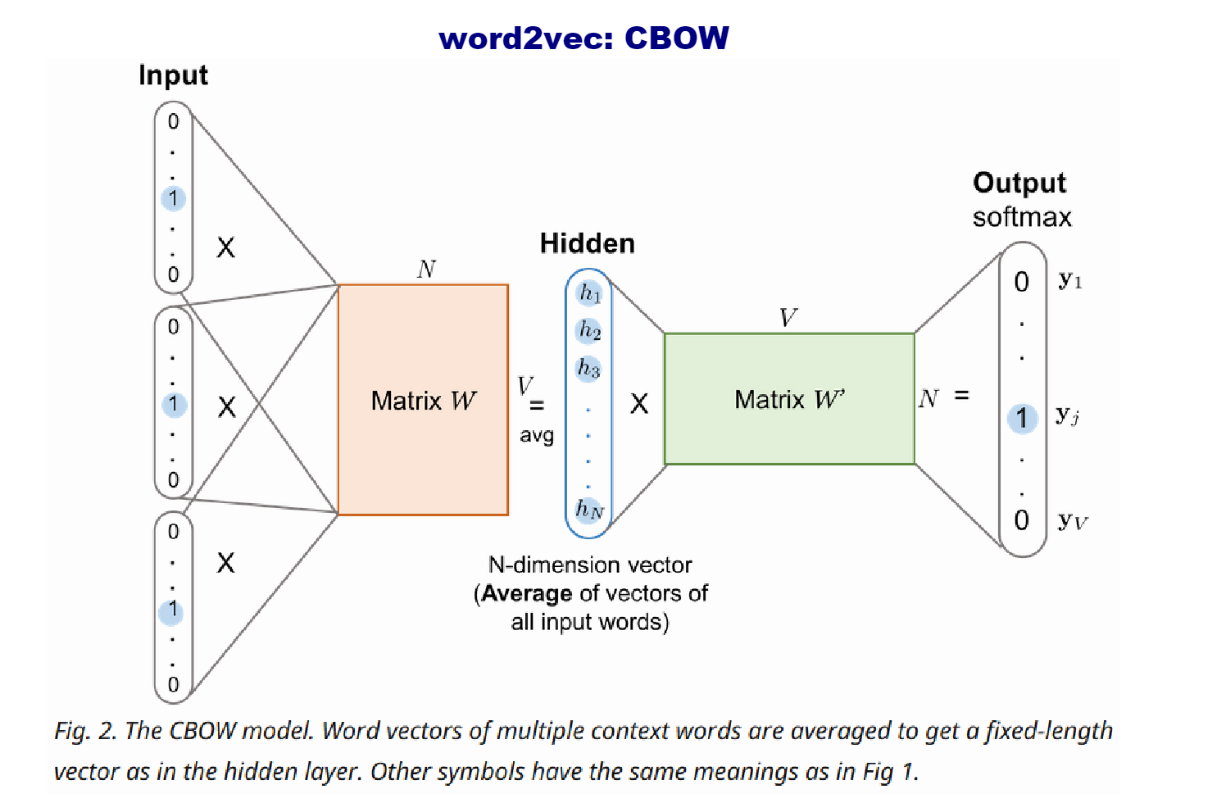

### Модель

Попрубуем реализовать свою модель и поэкспериментировать с рамером окна и рамерность пространства.

In [397]:
class CBOW(nn.Module):
     def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.layer1 = nn.Linear(vocab_size, embedding_size, bias=False)
        self.layer2 = nn.Linear(embedding_size, vocab_size, bias=False)
    
     def forward(self, inp):
        out = self.layer1(inp)
        out = self.layer2(out)
        return out

### Обучение модели, размер окна 3, размерность простарнства - 100

In [442]:
vocabulary, word2idx, idx2word, vocabulary_size =  get_vocabulary(freq, 16800)

In [444]:
context, target = get_context_target( vocabulary, word2idx, window_size = 3 )

In [403]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

embedding_dims = 100
cbow = CBOW(vocabulary_size, embedding_dims).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    cbow.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

cbow  =  train_model(cbow, context, target, vocabulary_size, criterion, optimizer, num_epochs=30)

In [404]:
torch.save(cbow.state_dict(), "./cbow100_dict.pth")

In [405]:
cbow.load_state_dict(torch.load('/content/cbow100_dict.pth'))

<All keys matched successfully>

In [330]:
embeddings = list(cbow.parameters())[0].T.cpu().detach().numpy()
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(embeddings)

In [365]:
man, woman = word2idx['men'], word2idx['women']
girl, boy = word2idx['girl'], word2idx['boy']

Попробуем посмотреть ближайших соседей в полученном пространстве.

In [382]:
ind = neigh.kneighbors(embeddings[man].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед слову <men>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[woman].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед слову <women>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[girl].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед слову <girl>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[boy].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед слову <boy>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

Ближайшие соседик слову <men>:  ['men', 'incidentally', 'relaxing', 'hourandtenminutedelay', 'seevery']
Ближайшие соседик слову <women>:  ['women', 'dozen', 'mrandyep', 'sites', '409']
Ближайшие соседик слову <girl>:  ['girl', 'opinions', '2009', 'honorable', 'lugging']
Ближайшие соседик слову <boy>:  ['boy', 'hrsthere', 'kitty', 'pouting', 'buffaloairport']


Человеку данные слова не явялются близкими. Ожидалось увидеть рядом слова 'man' и 'boy', 'girl' и 'woman' (или группировка по возрасту:'man' и 'woman'). То, что такие слова как 'boy', 'kitty' и 'pouting' являются соседями, вызывает сомнения о качестве пространства.

In [301]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


Теперь попробуем провизуализировать некоторые вектора в двумерном представлении с помощью t-SNE. 

In [ ]:
# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_tsne= tsne.fit_transform(embeddings)

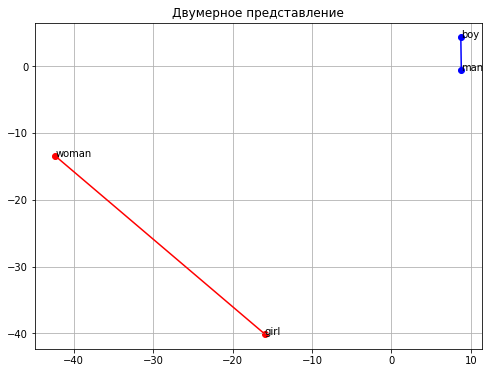

In [370]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title('Двумерное представление')

plt.text(embeddings_tsne[:, 0][boy], embeddings_tsne[:,1][boy],  'boy')
plt.text(embeddings_tsne[:, 0][girl], embeddings_tsne[:, 1][girl], 'girl')
plt.text(embeddings_tsne[:, 0][man],embeddings_tsne[:, 1][man], 'man')
plt.text(embeddings_tsne[:, 0][woman], embeddings_tsne[:, 1][woman], 'woman')

plt.scatter(embeddings_tsne[:, 0][boy], embeddings_tsne[:,1][boy],  c='b')
plt.scatter(embeddings_tsne[:, 0][girl], embeddings_tsne[:, 1][girl], c='r')
plt.scatter(embeddings_tsne[:, 0][man],embeddings_tsne[:, 1][man], c='b')
plt.scatter(embeddings_tsne[:, 0][woman], embeddings_tsne[:, 1][woman], c='r')

plt.plot([embeddings_tsne[:, 0][boy], embeddings_tsne[:, 0][man]], [embeddings_tsne[:,1][boy], embeddings_tsne[:, 1][man]], c='b')
plt.plot([embeddings_tsne[:, 0][girl], embeddings_tsne[:, 0][woman]], [embeddings_tsne[:,1][girl], embeddings_tsne[:, 1][woman]], c='r')

plt.show()

Радует, что слова 'boy' и 'man' находятся нетак уж и далеко друг от друга. вектора назвать колиннеарными сложно.

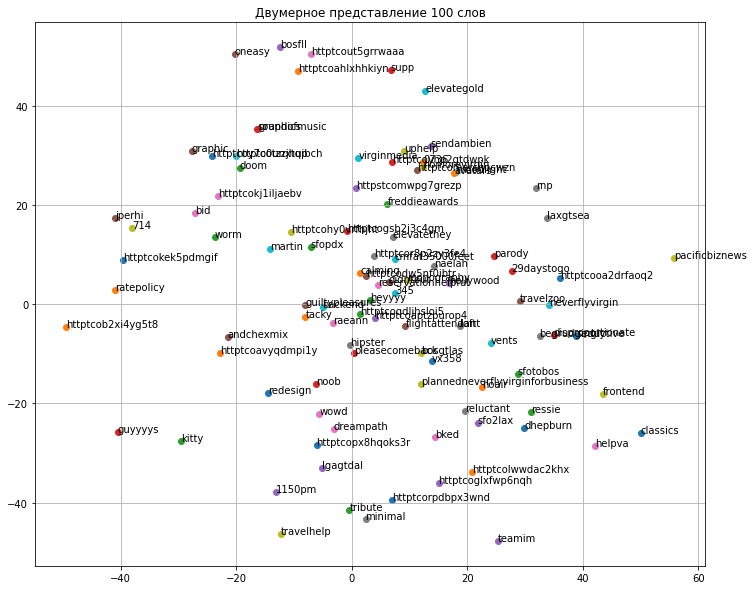

In [371]:
plt.figure(figsize=(12,10))
plt.title('Двумерное представление 100 слов')
for i in range(100):
    plt.scatter(embeddings_tsne[:, 0][i],embeddings_tsne[:, 1][i] )
    plt.text(embeddings_tsne[:, 0][i],embeddings_tsne[:, 1][i], idx2word[i])
plt.grid()

На графике выше были продемонстрированы 100 слов в нашем новом признаковом пространстве. Ожидалось увидеть кластеры слов или хотя бы группы слов, объединенных по смыслу.

**Вывод**: Качество данного пространства низкое. Параметры, которые были взяты не подходят для данной задачи.

### Обучение модели, размер окна 3, размерность простарнства - 300

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

embedding_dims = 300
cbow = CBOW(vocabulary_size, embedding_dims).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    cbow.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

cbow  =  train_model(cbow, context, target, vocabulary_size, criterion, optimizer, num_epochs=30)

In [ ]:
torch.save(cbow.state_dict(), "./cbow300_dict.pth")

In [ ]:
embeddings = list(cbow.parameters())[0].T.cpu().detach().numpy()
neigh = NearestNeighbors(n_neighbors=5, metric='cosine')
neigh.fit(embeddings)

NearestNeighbors(metric='cosine')

In [ ]:
man, woman = word2idx['men'], word2idx['women']
girl, boy = word2idx['girl'], word2idx['boy']

In [ ]:
ind = neigh.kneighbors(embeddings[man].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед к слову <men>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[woman].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед к слову <women>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[girl].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед к слову <girl>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[boy].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед к слову <boy>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

Ближайшие сосед к слову <men>:  ['men', 'hournot', 'holdguess', 'theres', 'gsp']
Ближайшие сосед к слову <women>:  ['women', 'inconvenienced', 'saturday', 'bday', '13']
Ближайшие сосед к слову <girl>:  ['girl', 'young', 'alone', 'retweet', 'flown']
Ближайшие сосед к слову <boy>:  ['boy', 'guiltypleasures', 'arizona', '219221', 'superhero']


Кажется, что пространство стало немного лучше. Среди слов ближайших к слову 'girl' есть слова 'young', 'alone', что можно хоть как-то проинтерпетировать.

In [ ]:
# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_tsne= tsne.fit_transform(embeddings)

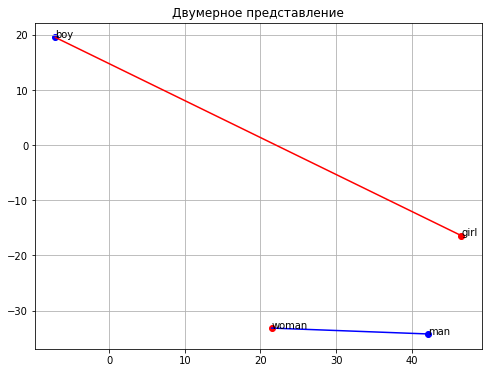

In [ ]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title('Двумерное представление')

plt.text(embeddings_tsne[:, 0][boy], embeddings_tsne[:,1][boy],  'boy')
plt.text(embeddings_tsne[:, 0][girl], embeddings_tsne[:, 1][girl], 'girl')
plt.text(embeddings_tsne[:, 0][man],embeddings_tsne[:, 1][man], 'man')
plt.text(embeddings_tsne[:, 0][woman], embeddings_tsne[:, 1][woman], 'woman')

plt.scatter(embeddings_tsne[:, 0][boy], embeddings_tsne[:,1][boy],  c='b')
plt.scatter(embeddings_tsne[:, 0][girl], embeddings_tsne[:, 1][girl], c='r')
plt.scatter(embeddings_tsne[:, 0][man],embeddings_tsne[:, 1][man], c='b')
plt.scatter(embeddings_tsne[:, 0][woman], embeddings_tsne[:, 1][woman], c='r')

plt.plot([embeddings_tsne[:, 0][woman], embeddings_tsne[:, 0][man]], [embeddings_tsne[:, 1][woman], embeddings_tsne[:, 1][man]], c='b')
plt.plot([embeddings_tsne[:, 0][girl], embeddings_tsne[:, 0][boy]], [embeddings_tsne[:,1][girl], embeddings_tsne[:, 1][boy]], c='r')

plt.show()

Здесь можно построить дргугие вектора, которые почти колиннеарны! Это гворит о том, что качество пространства повысилось.

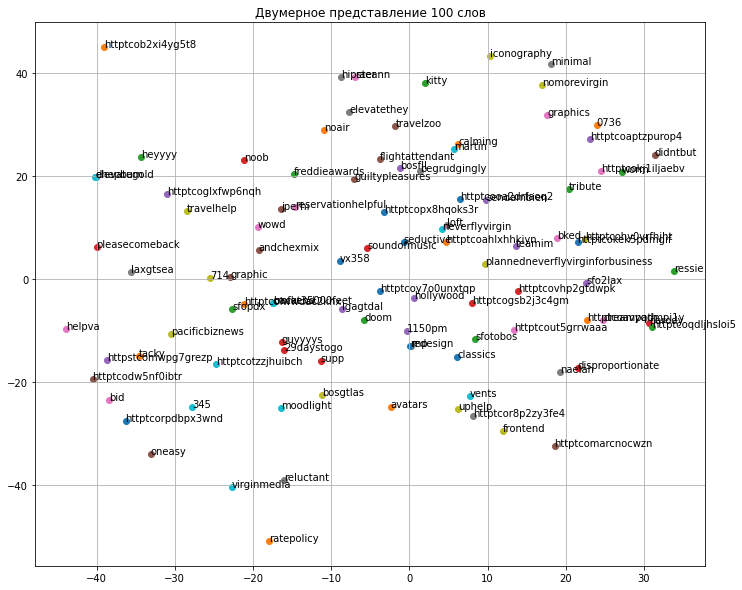

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Двумерное представление 100 слов')
for i in range(100):
    plt.scatter(embeddings_tsne[:, 0][i],embeddings_tsne[:, 1][i] )
    plt.text(embeddings_tsne[:, 0][i],embeddings_tsne[:, 1][i], idx2word[i])
plt.grid()

Попрежнему сложно сказать что-то исходя из этой визуализации.

**Вывод**: повысив размерность признакого пространства мы смогли улучшить качество!

### Обучение модели, размер окна 3, размерность простарнства - 1000

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

embedding_dims = 1000
cbow = CBOW(vocabulary_size, embedding_dims).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    cbow.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

cbow  =  train_model(cbow, context, target, vocabulary_size, criterion, optimizer, num_epochs=30)

In [ ]:
embeddings = list(cbow.parameters())[0].T.cpu().detach().numpy()
neigh = NearestNeighbors(n_neighbors=5, metric='cosine')
neigh.fit(embeddings)

NearestNeighbors(metric='cosine')

In [ ]:
man, woman = word2idx['men'], word2idx['women']
girl, boy = word2idx['girl'], word2idx['boy']

In [ ]:
ind = neigh.kneighbors(embeddings[man].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед к слову <men>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[woman].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед к слову <women>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[girl].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед к слову <girl>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

ind = neigh.kneighbors(embeddings[boy].reshape(1, -1), return_distance=False)[0]
print('Ближайшие сосед к слову <boy>: ', [idx2word[ind[k]] for k in range(ind.shape[0])])

Ближайшие сосед к слову <men>:  ['men', 'jaramillo', 'lostyou', 'httptcom2wsg2olgo', 'curvygirltravels']
Ближайшие сосед к слову <women>:  ['women', 'flightno', 'dancing', '10hour', 'signin']
Ближайшие сосед к слову <girl>:  ['girl', 'mean', 'treats', 'pretzels', 'nuts']
Ближайшие сосед к слову <boy>:  ['boy', 'brothaaaaaa', 'durango', 'complimentary', 'motions']


К сожалению, по ближайшим словам, сделать какие-то выводы нельзя. Разве что слова не похожи.

In [ ]:
# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_tsne= tsne.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


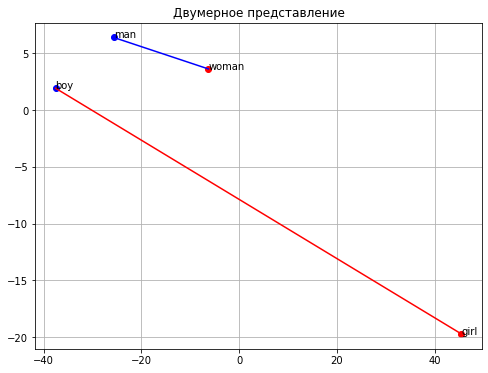

In [ ]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.title('Двумерное представление')

plt.text(embeddings_tsne[:, 0][boy], embeddings_tsne[:,1][boy],  'boy')
plt.text(embeddings_tsne[:, 0][girl], embeddings_tsne[:, 1][girl], 'girl')
plt.text(embeddings_tsne[:, 0][man],embeddings_tsne[:, 1][man], 'man')
plt.text(embeddings_tsne[:, 0][woman], embeddings_tsne[:, 1][woman], 'woman')

plt.scatter(embeddings_tsne[:, 0][boy], embeddings_tsne[:,1][boy],  c='b')
plt.scatter(embeddings_tsne[:, 0][girl], embeddings_tsne[:, 1][girl], c='r')
plt.scatter(embeddings_tsne[:, 0][man],embeddings_tsne[:, 1][man], c='b')
plt.scatter(embeddings_tsne[:, 0][woman], embeddings_tsne[:, 1][woman], c='r')

plt.plot([embeddings_tsne[:, 0][woman], embeddings_tsne[:, 0][man]], [embeddings_tsne[:, 1][woman], embeddings_tsne[:, 1][man]], c='b')
plt.plot([embeddings_tsne[:, 0][girl], embeddings_tsne[:, 0][boy]], [embeddings_tsne[:,1][girl], embeddings_tsne[:, 1][boy]], c='r')

plt.show()

Вектора стали ну уж совсем почти идеальные. Они почти параллельны друг к другу. Также логично их расположение. 'boy' находится ближе к 'man', 'girl' к 'woman'.

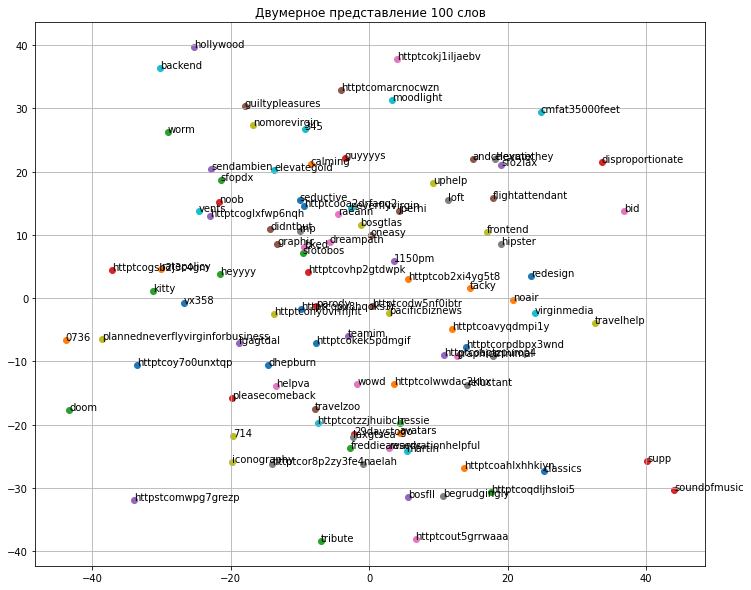

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Двумерное представление 100 слов')
for i in range(100):
    plt.scatter(embeddings_tsne[:, 0][i],embeddings_tsne[:, 1][i] )
    plt.text(embeddings_tsne[:, 0][i],embeddings_tsne[:, 1][i], idx2word[i])
plt.grid()

К сожалению, по прежнему из этой визуализации нельзя сделать выводов.

**Вывод**: из протестированных моеделей, эта показала себя лучше всех. Построенные вектора почти параллельны, а значит наше пространство имеет какой-то смысл. Но данная модель очень долго обучалась.

### Вывод
Для хорошего качества пространства требуется больший корпус для обучения, а также больше вычислительных мощностей. 

Но в перспективе данный метод эмбеддинга может показать хорошие результаты при увеличении признакого пространства.

Здесь можно было ещё много всего реализовать. Например, другие методы неконтектсного моделирования. Сделать больше экспериментов с размером окна и размером признакого пространства. Также можно было бы попробовать разные методы сокращения количества слов в словаре.